In [1]:
from sklearn.neighbors import BallTree, KDTree
import matplotlib.pyplot as plt

In [2]:
import random
import numpy as np

def generate(N, dim, steps=10):
    res = np.zeros((N, dim))
    bins = steps ** dim
    for i in range(N):
        cell = random.randrange(bins)
        for d in range(dim):
            idx = (cell // steps ** d) % steps
            res[i, d] = idx / steps + random.random() / steps
    return res

In [ ]:
data2d = generate(30000, 2)
plt.figure(figsize=(15, 15))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0])

## 1. Build tree indices: KDTree, BallTree, [VPTree](https://pypi.org/project/vptree/), and Annoy

Simple case. 2D points, Euclidean distance.

In [4]:
!pip install annoy vptree

In [5]:
from annoy import AnnoyIndex
from vptree import VPTree
import time
import numpy as np

In [6]:
bucket2d = generate(200, 2)

## 1.0. Prepare ground truth

In [7]:
from scipy.spatial.distance import euclidean
from tqdm import tqdm


def get_GT(data, bucket):
    gt = []
    for i, row_b in enumerate(tqdm(bucket)):
        d = []
        for j, row_d in enumerate(data):
            d.append(euclidean(row_b, row_d))
        gt.append(np.argsort(d)[:1000])
    return gt

GT = get_GT(data2d, bucket2d)

100%|██████████| 200/200 [00:30<00:00,  6.51it/s]


## 1.00. Recall

In [8]:
def recall(i1, i2, N=1000):
    return len(set(i1).intersection(i2)) / N

## 1.1. KD Tree

In [9]:
start = time.time()
kdtree = # TODO build the index given `data2d` array
print(f"KDTree is ready in {time.time() - start :.5f} s")

KDTree is ready in 0.01035 s


(3000, 2)


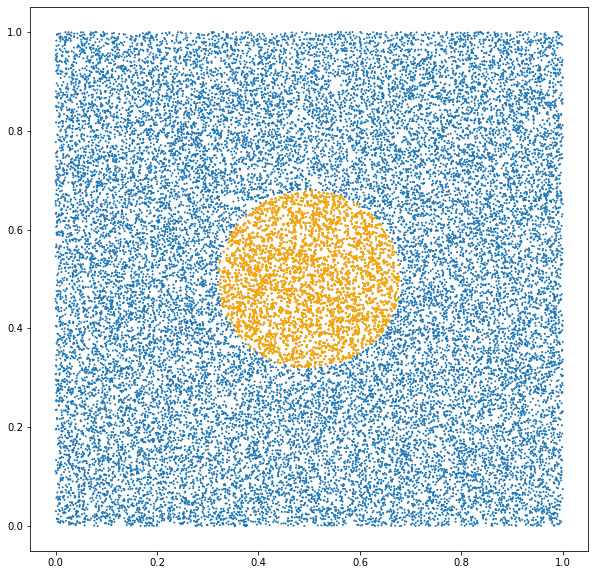

In [10]:
idx = kdtree.query([(.5, .5)], 3000, return_distance=False)[0]
points = data2d[idx, :]
print(points.shape)

# TODO: plot the picture like this

In [11]:
start = time.time()
r = kdtree.query(bucket2d, 1000, return_distance=False)
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.02478 s
Recall@1000 = 1.0000


## 1.2. Ball Tree

In [12]:
start = time.time()
balltree = # TODO build the index given `data2d` array
print(f"BallTree is ready in {time.time() - start :.5f} s")

BallTree is ready in 0.00978 s


(3000, 2)


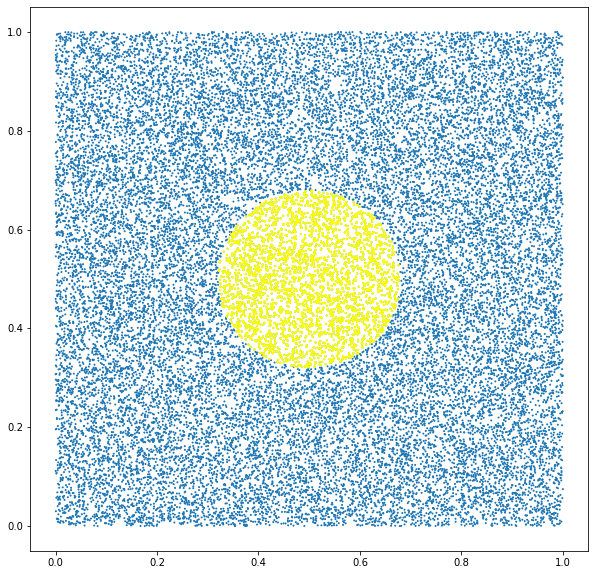

In [13]:
idx = balltree.query([(.5, .5)], 3000, return_distance=False)[0]
points = data2d[idx, :]
print(points.shape)
# TODO plot the picture

In [14]:
start = time.time()
r = balltree.query(bucket2d, 1000, return_distance=False)
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.03779 s
Recall@1000 = 1.0000


Is there any improvement compared to KDTree?

## 1.3. Annoy

### 1.3.1. Single tree

In [15]:
start = time.time()
annoy1 = # build the index with a SINGLE tree
print(f"Annoy is ready in {time.time() - start:.5} s")

Annoy is ready in 0.064816 s


(3000, 2)


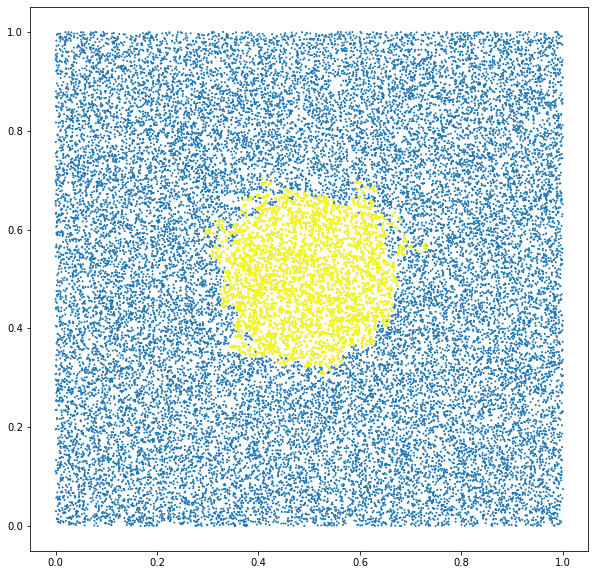

In [16]:
idx = annoy1.get_nns_by_vector([.5, .5], 3000)
points = data2d[idx, :]
print(points.shape)
# TODO plot the picture

In [17]:
start = time.time()
r = [annoy1.get_nns_by_vector(q, 1000) for q in bucket2d]
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.02974 s
Recall@1000 = 0.9187


### 1.3.2. Annoy more trees

Annoy is ready in 0.072049 s
(3000, 2)


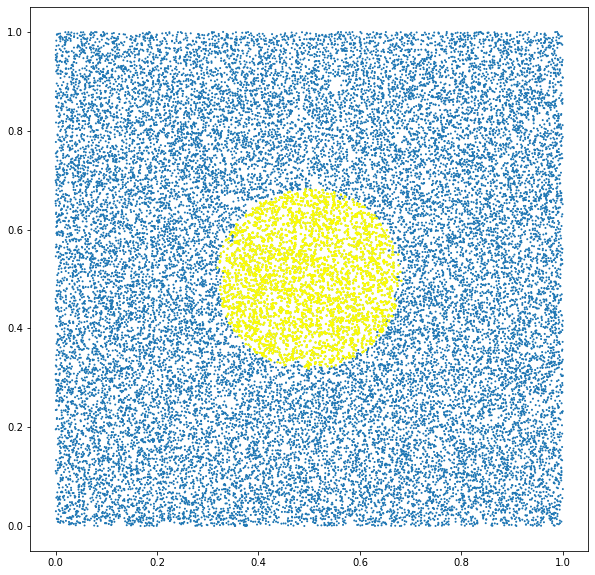

In [18]:
start = time.time()
annoy3 = # TODO build the index with exactly 3 trees
print(f"Annoy is ready in {time.time() - start:.5} s")

idx = annoy3.get_nns_by_vector([.5, .5], 3000)
points = data2d[idx, :]
print(points.shape)
# Plot the pic

In [19]:
start = time.time()
r = [annoy3.get_nns_by_vector(q, 1000) for q in bucket2d]
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.06774 s
Recall@1000 = 0.9803


What changed?

### 1.4. Vantage Point Tree

In [20]:
start = time.time()
vptree = VPTree(list(enumerate(data2d)), lambda x, y: euclidean(x[1], y[1]))
print(f"VPTree is ready in {time.time() - start :.5f} s")

/Users/sprotasov/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


VPTree is ready in 2.75022 s


(3000, 2)


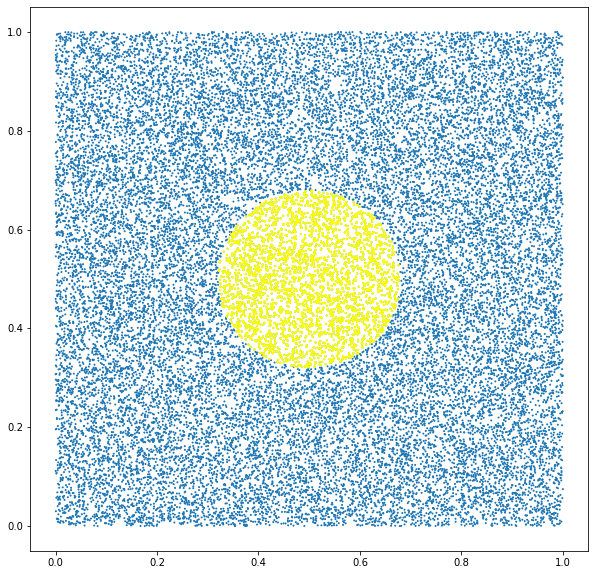

In [21]:
idx = [x[1][0] for x in vptree.get_n_nearest_neighbors([.5, .5], 3000)]
points = data2d[idx, :]
print(points.shape)
# TODO the pic!

In [22]:
start = time.time()
r = [[x[1][0] for x in vptree.get_n_nearest_neighbors(q, 1000)] for q in bucket2d]
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
# print([recall(GT[i], r[i]) for i in range(len(bucket2d))])
print(f"Recall@1000 = {rec:.4f}")

Queries done in 25.89180 s
Recall@1000 = 0.2015


Vantage Point tree: what is the reason to be soo slow? Is there any reason to trust python libraries?

# 2. Scalability testing

In [ ]:
statistics = {"D":[], "tree":[], "construction":[], "search":[], "recall":[]}

for D in [2, 5, 10, 15, 50, 100, 200]:
    data = generate(50000, D)
    bucket = generate(50, D)
    
    myGT = get_GT(data, bucket)
    
    ###################################
    print(f"kdtree {D}")
    start = time.time()
    kdtree = KDTree(data)
    statistics["D"].append(D)
    statistics["tree"].append("kdtree")
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r = kdtree.query(bucket, 1000, return_distance=False)
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################
    
    ###################################
    print(f"balltree {D}")
    start = time.time()
    balltree = BallTree(data)
    statistics["D"].append(D)
    statistics["tree"].append("balltree")
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r = balltree.query(bucket, 1000, return_distance=False)
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################
    
    ###################################
    print(f"annoy-20 {D}")
    statistics["D"].append(D)
    statistics["tree"].append("annoy20")

    start = time.time()
    annoy20 = AnnoyIndex(data.shape[1], 'euclidean')
    for i, v in enumerate(data):
        annoy20.add_item(i, v)
    annoy20.build(20, n_jobs=-1)
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r  = [annoy20.get_nns_by_vector(q, 1000) for q in bucket]
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################
    
    ###################################
    print(f"annoy-100 {D}")
    statistics["D"].append(D)
    statistics["tree"].append("annoy100")

    start = time.time()
    annoy100 = AnnoyIndex(data.shape[1], 'euclidean')
    for i, v in enumerate(data):
        annoy100.add_item(i, v)
    annoy100.build(100, n_jobs=-1)
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r  = [annoy100.get_nns_by_vector(q, 1000) for q in bucket]
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################

In [ ]:
import pandas as pd
df = pd.DataFrame(statistics)
df

In [ ]:
types = set(df['tree'])
markers = dict(zip(types, ["*", "", "+", "^"]))

plt.figure(figsize=(15, 6))
plt.title("Construction time")
for typ in types:
    x = df[df['tree'] == typ]['D']
    y = df[df['tree'] == typ]['construction']
    plt.plot(x, y, label=typ, marker=markers[typ])
plt.xlabel("Dimensions")
plt.ylabel("Seconds")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.title("Search time")
for typ in types:
    x = df[df['tree'] == typ]['D']
    y = df[df['tree'] == typ]['search']
    plt.plot(x, y, label=typ, marker=markers[typ])
plt.ylabel("Seconds")
plt.xlabel("Dimensions")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.title("Recall@1000")
for typ in types:
    x = df[df['tree'] == typ]['D']
    y = df[df['tree'] == typ]['recall']
    plt.plot(x, y, label=typ, marker=markers[typ])
plt.xlabel("Dimensions")
plt.ylabel("recall@1000")
plt.legend()
plt.show()

# 3. Questions to discuss

1. Should we trust `pip`-based implementations? If no, how to validate?
2. What should be the strategy to choose index structure for your data? Take dimensions, size, implementations into account.
3. We measured 3 numbers, representing data structures. Can we consider anything else? Open http://ann-benchmarks.com/ and see, what they care about.
4. Is there anything missing in their benchmarks?

# 4. Advanced problem

What will change in the picture, if you change `euclidean` metric with `cosine`? Can you implement this?